In [17]:
import os
import math
import warnings
import operator
import pandas as pd
import numpy as np
import datetime as dt
import logging
import gcsfs

from pandas.io import gbq
from datetime import date, timedelta
from datetime import datetime
from google.cloud import storage
from factor_analyzer import FactorAnalyzer
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv('gs://aes-datahub-0001-raw/Weather/Weather_Source/USA/Indianapolis/Historical_Data/Storm_Data_2007-2019/Weather_Source_All_Marker.csv')

In [3]:
dataframe = df.filter(regex=("Avg"))

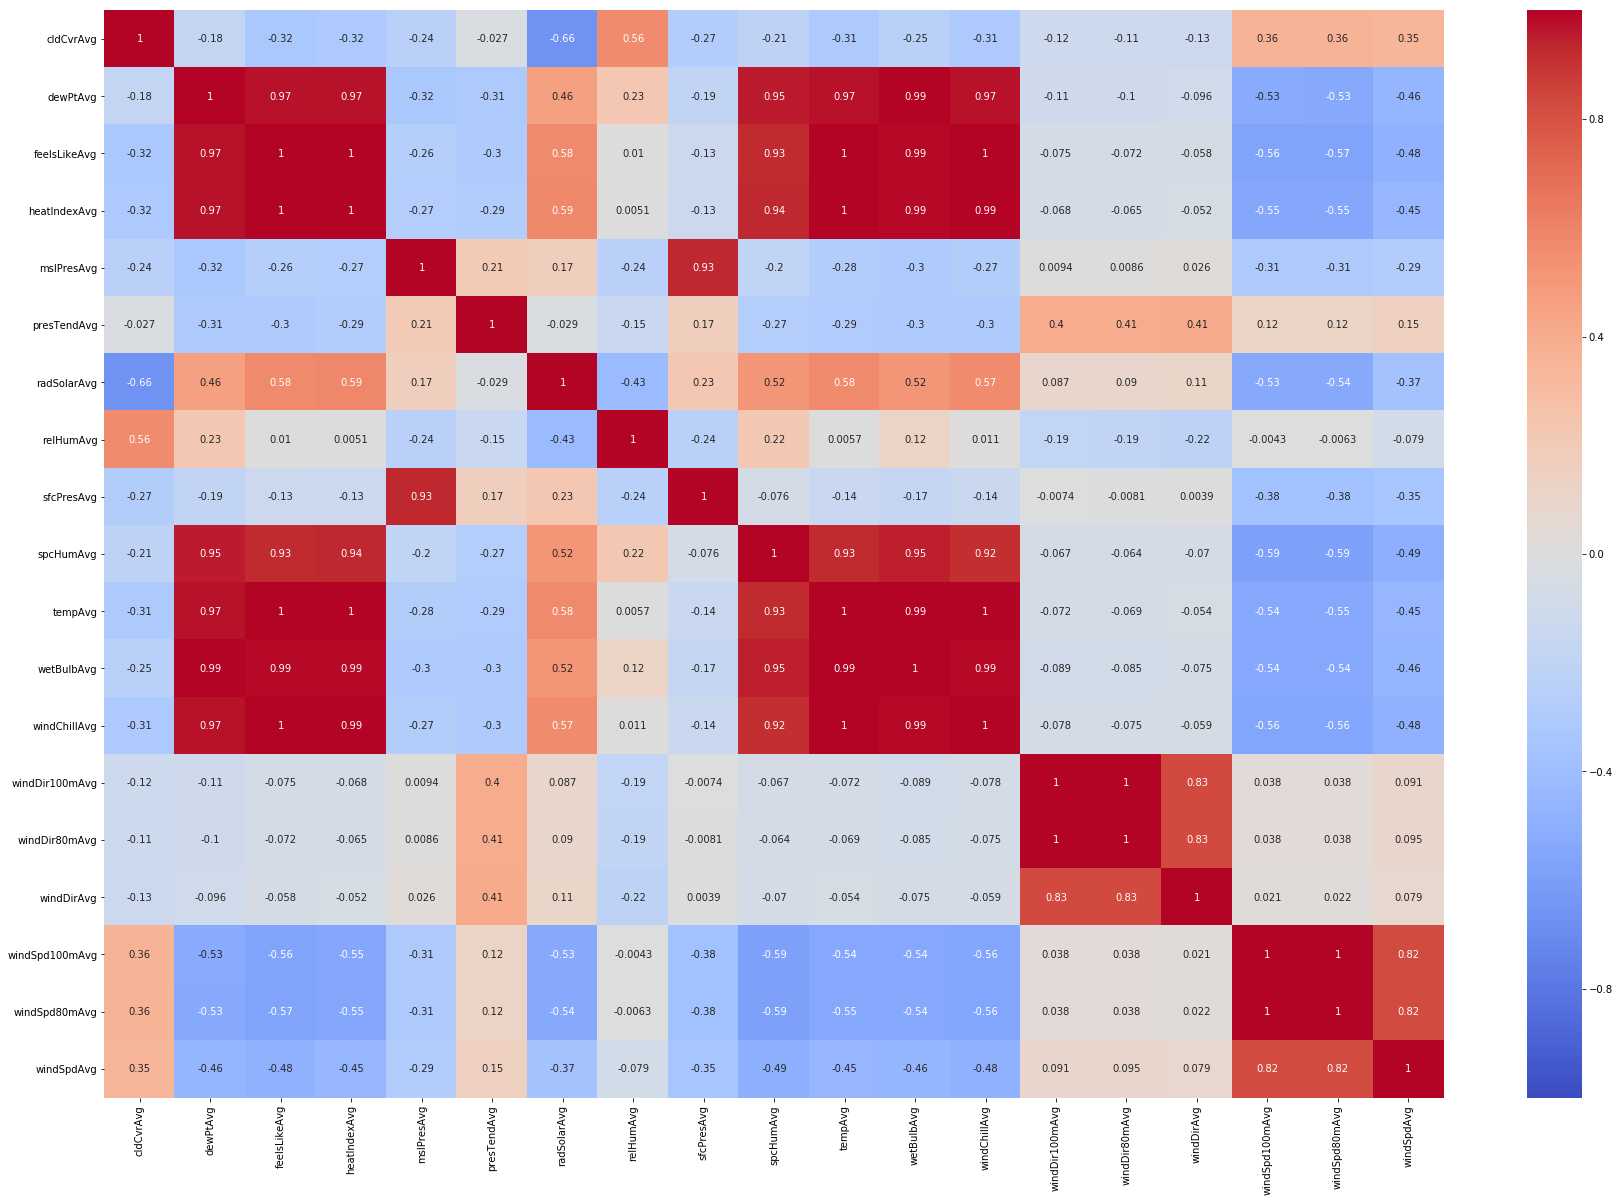

In [4]:
plt.figure(figsize=(30,20))
c= dataframe.corr()
sns.heatmap(c, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

In [5]:
print(dataframe.columns)
print(dataframe.isnull().sum())

Index(['cldCvrAvg', 'dewPtAvg', 'feelsLikeAvg', 'heatIndexAvg', 'mslPresAvg', 'presTendAvg', 'radSolarAvg', 'relHumAvg', 'sfcPresAvg', 'spcHumAvg', 'tempAvg', 'wetBulbAvg', 'windChillAvg', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg', 'windSpd80mAvg', 'windSpdAvg'], dtype='object')
cldCvrAvg         0
dewPtAvg          0
feelsLikeAvg      0
heatIndexAvg      0
mslPresAvg        0
presTendAvg       0
radSolarAvg       0
relHumAvg         0
sfcPresAvg        0
spcHumAvg         0
tempAvg           0
wetBulbAvg        0
windChillAvg      0
windDir100mAvg    0
windDir80mAvg     0
windDirAvg        0
windSpd100mAvg    0
windSpd80mAvg     0
windSpdAvg        0
dtype: int64


In [6]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(dataframe)
chi_square_value, p_value

(554563.9881363543, 0.0)

In [7]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(dataframe)

In [8]:
kmo_model

0.7833254849162683

In [9]:
fa = FactorAnalyzer()
fa.set_params(n_factors=10, rotation=None)
fa.fit(dataframe)
ev, v = fa.get_eigenvalues()
ev

array([8.60274133e+00, 3.46721665e+00, 2.86419661e+00, 1.51450199e+00,
       7.34125121e-01, 6.15426399e-01, 3.60492929e-01, 3.23829018e-01,
       2.21571471e-01, 1.73396498e-01, 6.22327337e-02, 5.23616882e-02,
       2.80664134e-03, 2.24502960e-03, 1.53532676e-03, 5.57805794e-04,
       4.04330429e-04, 3.58363198e-04, 6.52131239e-08])

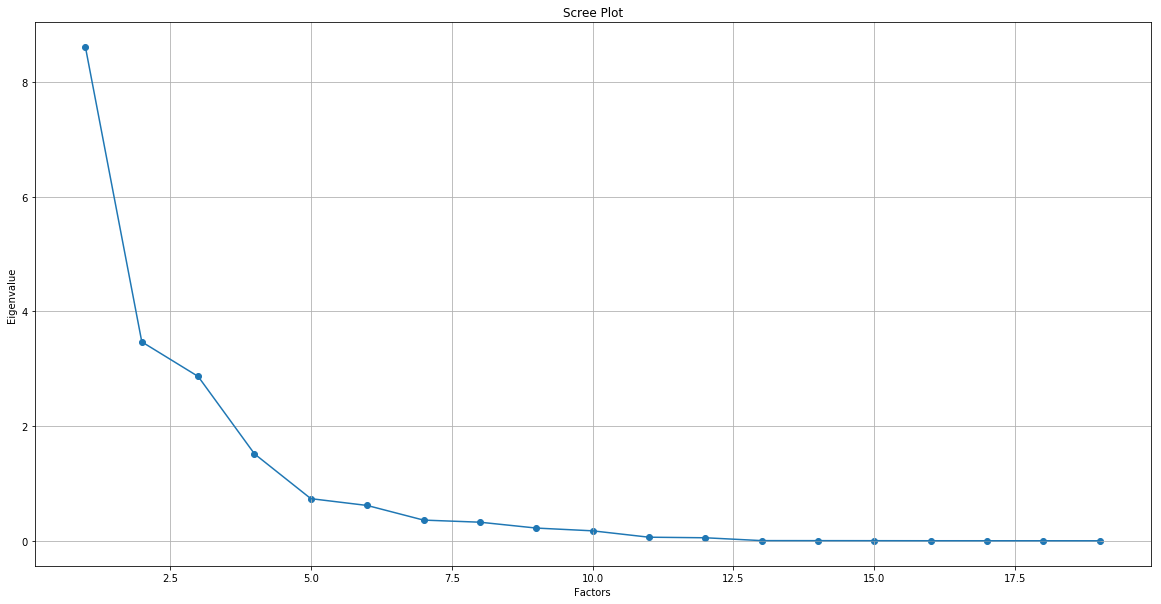

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(range(1,dataframe.shape[1]+1),ev)
plt.plot(range(1,dataframe.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [11]:
fa = FactorAnalyzer(5, rotation='varimax')
fa.fit(dataframe)
loads = fa.loadings_
print(loads)
print(type(loads))

[[-0.20357398 -0.07942054  0.225171   -0.13248522  0.72660441]
 [ 0.96446384 -0.0856653  -0.2113668  -0.11490599  0.07951463]
 [ 0.95588622 -0.0680632  -0.21626978 -0.09506382 -0.14450696]
 [ 0.96272771 -0.06041928 -0.191169   -0.09140514 -0.1490967 ]
 [-0.26219738  0.02736288 -0.23823072  0.90944628 -0.1628634 ]
 [-0.25097778  0.42510435  0.06681932  0.15346282 -0.05758875]
 [ 0.4841094   0.07478446 -0.2673836   0.13788303 -0.61118532]
 [ 0.10662968 -0.14369247 -0.10077795 -0.10947448  0.81529441]
 [-0.13472438  0.00919351 -0.2654418   0.88553697 -0.17959975]
 [ 0.92098909 -0.04534088 -0.26860137 -0.00848419  0.06130225]
 [ 0.96080579 -0.06439584 -0.18947152 -0.10552442 -0.14640293]
 [ 0.96956018 -0.07357455 -0.2011665  -0.10795207 -0.03143023]
 [ 0.95123715 -0.07160102 -0.21600445 -0.10721098 -0.14161416]
 [-0.01847759  0.9888607   0.00942613 -0.0332182  -0.05679064]
 [-0.01435386  0.99078511  0.01281218 -0.03217232 -0.05678718]
 [-0.0190954   0.83891621  0.01105445 -0.01787175 -0.10

In [12]:
fa.get_factor_variance()

(array([7.24499848, 2.91698761, 2.68398298, 1.87552442, 1.77101353]),
 array([0.38131571, 0.15352566, 0.14126226, 0.09871181, 0.09321124]),
 array([0.38131571, 0.53484137, 0.67610364, 0.77481545, 0.86802669]))

In [13]:
data_Z = dataframe.apply(zscore)

In [14]:
data_Z

,cldCvrAvg,dewPtAvg,feelsLikeAvg,heatIndexAvg,mslPresAvg,presTendAvg,radSolarAvg,relHumAvg,sfcPresAvg,spcHumAvg,tempAvg,wetBulbAvg,windChillAvg,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd80mAvg,windSpdAvg
0,0.31,-1.62,-1.89,-1.68,1.05,-2.26,-0.62,0.08,0.73,-1.58,-1.71,-1.70,-1.92,-1.39,-1.39,-1.39,1.48,1.48,3.04
1,-0.53,-0.06,0.19,0.17,-0.41,-0.74,0.52,-1.29,-0.31,-0.37,0.22,0.06,0.23,-0.03,-0.03,-0.03,0.83,0.83,1.94
2,1.16,-0.78,-0.89,-0.82,-2.02,-1.65,-1.41,-0.05,-2.01,-1.07,-0.81,-0.81,-0.88,-0.89,-0.89,-0.95,0.88,0.89,1.91
3,-1.66,0.18,0.75,0.77,-0.40,-1.04,1.46,-2.37,-0.24,-0.06,0.84,0.46,0.81,-0.12,-0.12,-0.05,-0.72,-0.72,-0.46
4,-0.67,0.29,0.54,0.52,-1.64,-1.04,0.39,-1.29,-1.45,0.10,0.58,0.40,0.59,0.25,0.25,0.28,-0.73,-0.74,-0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,0.74,0.80,0.45,0.43,0.12,0.17,-0.54,1.48,-0.08,0.91,0.49,0.70,0.51,-0.24,-0.31,-0.39,-1.49,-1.42,-1.58
8496,-0.50,0.79,0.58,0.58,-0.97,-1.04,0.48,0.92,-1.17,0.93,0.60,0.73,0.60,-0.31,-0.40,-0.37,-1.47,-1.31,-1.28
8497,0.60,0.53,0.28,0.22,-1.25,1.08,-0.24,1.11,-1.39,0.46,0.28,0.44,0.34,0.81,0.76,0.84,0.19,0.38,-0.73
8498,0.24,0.58,0.47,0.44,-0.04,-1.35,0.95,0.35,-0.18,0.54,0.48,0.54,0.50,-0.81,-0.85,-0.78,0.40,0.38,-0.78


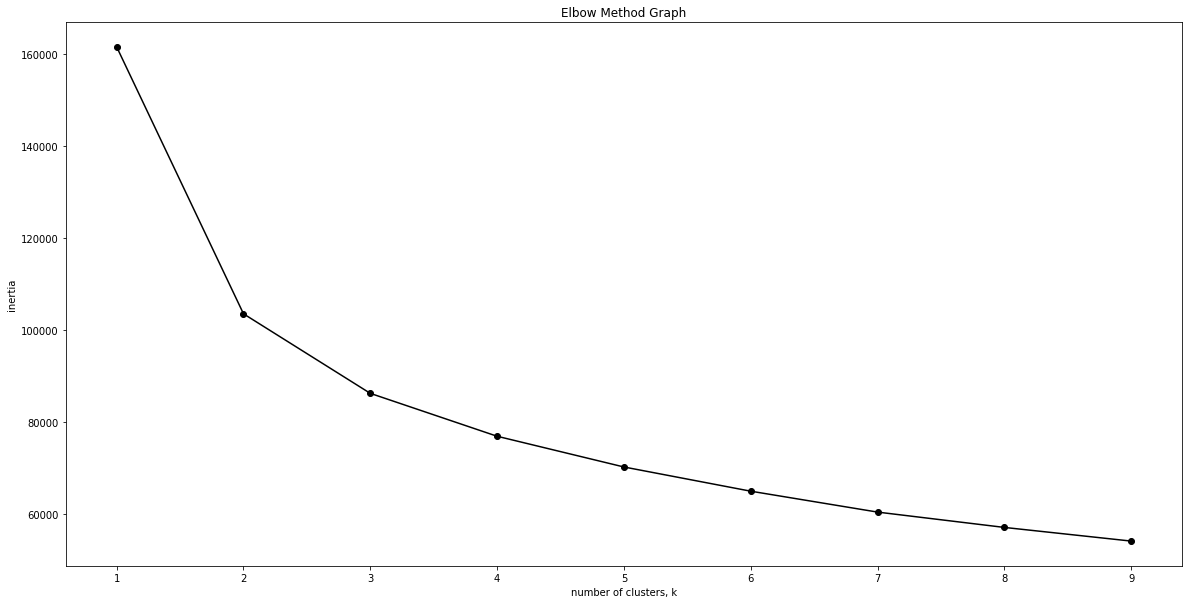

In [19]:
## Find Clusters 

ks = range(1, 10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(data_Z.iloc[:,:])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.figure(figsize=(20,10))   
plt.title('Elbow Method Graph')
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()